# Project McNulty: Predicting activity with physics

Gretta Ferguson

10/17/18

## Table of Contents

1. Import and format data
2. Visualize the data using PCA
3. Use GroupKFold to create a CV split
4. Tune parameters on full feature space
5. Tune parameters on limited feature space
6. Testing our chosen model
    

-----------
-----------
-----------
## 1. Import and format data

In [111]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.neighbors import KNeighborsClassifier


# from sklearn.ensemble import RandomForestClassifier
# from sklearn.feature_selection import SelectFromModel
# from sklearn.metrics import accuracy_score

from sklearn.model_selection import GridSearchCV, cross_val_predict

from sklearn.metrics import accuracy_score, confusion_matrix, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, auc, roc_auc_score, classification_report
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.naive_bayes import GaussianNB
from scipy import interp
from sklearn.naive_bayes import BernoulliNB

import pickle

from sklearn.ensemble import ExtraTreesClassifier


from skopt import BayesSearchCV
class BayesSearchCV(BayesSearchCV):
    def _run_search(self, x): raise BaseException('Use newer skopt')

pd.set_option('display.max_rows',10000)
pd.set_option('display.max_columns',600)

In [343]:
features = pd.read_csv('UCI HAR dataset/features.txt', delim_whitespace=True, header=None)
activity = pd.read_csv('UCI HAR dataset/activity_labels.txt', delim_whitespace=True, header=None)
subject = pd.read_csv('UCI HAR dataset/train/subject_train.txt', delim_whitespace=True, header=None)
X_train = pd.read_csv('UCI HAR dataset/train/X_train.txt', delim_whitespace=True, header=None)
y_train = pd.read_csv('UCI HAR dataset/train/y_train.txt', delim_whitespace=True, header=None)
intertial_body_acc_x_train = pd.read_csv('UCI HAR dataset/train/Inertial Signals/body_acc_x_train.txt', delim_whitespace=True, header=None)

In [346]:
activity

,ActivityID,Activity
0,1,WALKING
1,2,WALKING_UPSTAIRS
2,3,WALKING_DOWNSTAIRS
3,4,SITTING
4,5,STANDING
5,6,LAYING


In [345]:
y_train.columns=["ActivityID"]
activity.columns=["ActivityID","Activity"]
subject.columns=["SubjectID"]
X_train.columns=features

In [114]:
y_train_merged = y_train.merge(activity, left_on='ActivityID', right_on='ActivityID', how='left')
y_train_merged = pd.concat([y_train_merged, subject], axis=1)

In [115]:
yX=pd.concat([y_train_merged, X_train], axis=1)
y_train.head(2)

,ActivityID
0,5
1,5


In [116]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train))
X_train_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560
0,0.200642,-0.063683,-0.419628,-0.868814,-0.939441,-0.737529,-0.859817,-0.939019,-0.766437,-0.856036,-0.925985,-0.637379,0.906009,0.868656,0.738383,-0.885916,-0.693031,-0.775696,-0.670496,-0.833962,-0.925417,-0.807547,-0.649898,-1.238226,-1.179995,3.412525,-3.876175,1.632454,-0.821570,1.100072,-1.168302,0.498702,-0.341757,0.941865,-2.304371,1.927733,-0.482268,1.380895,1.899523,1.442277,0.579172,-0.407955,0.061692,-0.265753,-0.306419,0.553242,-0.256319,-0.328767,0.410710,0.564447,-0.438254,0.074860,0.587729,-0.396151,-0.068943,-0.740890,0.663114,-0.550392,-0.529470,-0.228543,-0.354146,0.248761,-0.91073,-0.465037,2.014245,-0.349498,0.182780,-0.009041,-0.160139,-1.367053,1.303594,-1.206294,1.072533,-2.089576,2.072447,-2.031693,1.965247,0.550414,0.769143,1.275707,-0.006244,-0.021715,-0.394860,-0.849792,-0.871020,-0.811184,-0.848909,-0.869117,-0.813021,-0.777446,-0.828429,-0.763608,0.845705,0.848865,0.800799,-0.865909,-0.681748,-0.716356,-0.567394,-0.838633,-0.856150,-0.799195,-1.103019,-1.088176,-1.229514,3.665646,-1.989598,2.380583,1.373978,1.143900,-0.534093,0.377887,0.253443,1.357246,-3.321014,1.193881,-2.591857,-0.939931,0.087009,-0.789081,0.115749,0.338443,0.151745,-0.862146,-0.809949,-0.895110,-0.852179,-0.805952,-0.883728,-0.792355,-0.723712,-0.859422,0.835059,0.839572,0.873707,-0.894028,-0.675010,-0.598854,-0.648936,-0.826943,-0.793635,-0.845767,0.502140,0.835307,-0.201994,1.112085,-1.798295,1.583435,-0.553818,5.671181,-5.852214,1.562693,1.136707,2.530433,-2.900124,2.576024,-1.835975,2.265385,0.340660,0.976351,-0.010059,-0.111668,-0.058844,-0.840979,-0.738341,-0.821210,-0.837306,-0.750762,-0.825353,-0.818357,-0.680128,-0.811505,0.823012,0.696987,0.750097,-0.827415,-0.606893,-0.440024,-0.586285,-0.825691,-0.759443,-0.817724,-0.980318,-1.241894,-0.924423,1.412544,-2.113256,1.146327,-1.032157,5.300794,-3.642777,1.591339,0.821957,2.7

--------
## 2. Visualize the data using PCA

In [347]:
pca_2D = PCA(n_components=2)
pca_2D.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [351]:
pcafeatures_train = pca_2D.transform(X_train)

In [375]:
from itertools import cycle

def plot_PCA_2D(data, target, target_names):

    plt.figure(figsize=[10,10])
    
    colors = cycle(['r','g','b','c','m','y'])
    target_ids = range(len(target_names))
    for i, c, label in zip(target_ids, colors, target_names):
        test = np.array(target == i)
        plt.scatter(data[test[:,0], 0], data[test[:,0], 1],
                   c=c, label=label)
        
    
    plt.legend()

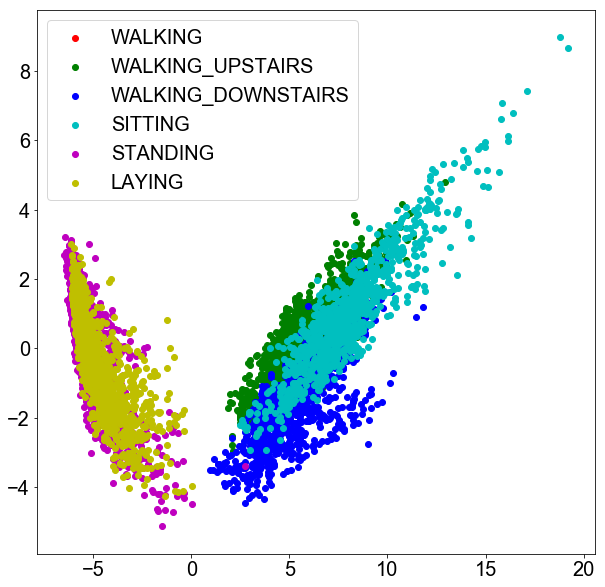

In [376]:
plot_PCA_2D(pcafeatures_train, target=y_train, target_names=np.array(activity['Activity']));

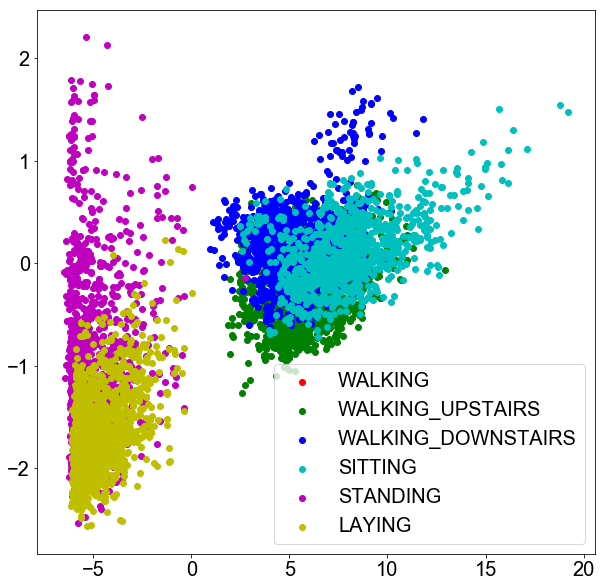

In [377]:
plot_PCA_2D(np.array(result[['PCA0','PCA2']]), target=y_train, target_names=np.array(activity['Activity']))

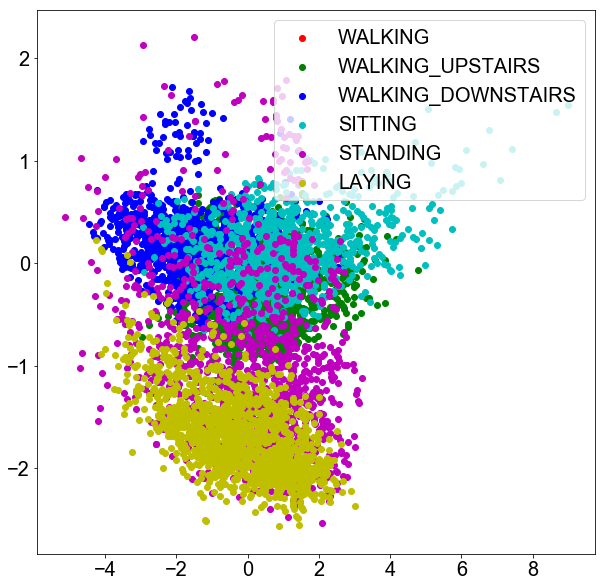

In [378]:
plot_PCA_2D(np.array(result[['PCA1','PCA2']]), target=y_train, target_names=np.array(activity['Activity']))

In [327]:
pca_3D = PCA(n_components=3)
pca_3D.fit(X_train)
result=pd.DataFrame(pca_3D.transform(X_train), columns=['PCA%i' % i for i in range(3)], index=X_train.index)

<Figure size 432x288 with 0 Axes>

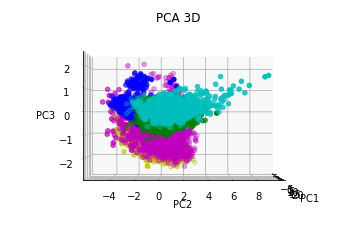

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [12]:
from mpl_toolkits.mplot3d import Axes3D

# Plot initialisation
fig = plt.figure()
 
    
def plot_PCA_3D(data, target, target_names):

    colors = cycle(['r','g','b','c','m','y'])
    target_ids = range(len(target_names))

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    for i, c, label in zip(target_ids, colors, target_names):
        test = np.array(target == i)
        
        ax.scatter(data[test[:,0], 0], data[test[:,0], 1], data[test[:,0], 2],
                   c=c, label=label)
#         ax.scatter(result['PCA0'], result['PCA1'], result['PCA2'], s=60)


    # label the axes
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    ax.set_title("PCA 3D")
#     plt.legend()


    for angle in range(0, 360):
        ax.view_init(0, 0)
        plt.draw()
        plt.pause(.001)

    #plt.show()
    
# Axes3D.scatter(xs, ys, zs=0, zdir='z', s=20, c=None, depthshade=True, *args, **kwargs)

plot_PCA_3D(pca_3D.transform(X_train), target=y_train, target_names=np.array(activity['Activity'])) 

### <span style="color:red">Need to make a 3d rotating plot</span> 

<Figure size 432x288 with 0 Axes>

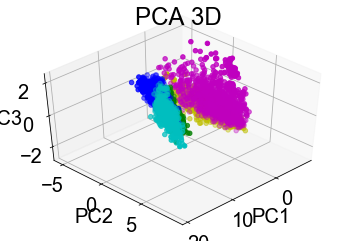

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [380]:
from mpl_toolkits.mplot3d import Axes3D

# Plot initialisation
fig = plt.figure()
 
    
def plot_PCA_3D(data, target, target_names):

    colors = cycle(['r','g','b','c','m','y'])
    target_ids = range(len(target_names))

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    for i, c, label in zip(target_ids, colors, target_names):
        test = np.array(target == i)
        
        ax.scatter(data[test[:,0], 0], data[test[:,0], 1], data[test[:,0], 2],
                   c=c, label=label)
#         ax.scatter(result['PCA0'], result['PCA1'], result['PCA2'], s=60)


    # label the axes
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    ax.set_title("PCA 3D")
#     plt.legend()


    for angle in range(0, 360):
        ax.view_init(45,45)
        plt.draw()
        plt.pause(.001)

    #plt.show()
    
# Axes3D.scatter(xs, ys, zs=0, zdir='z', s=20, c=None, depthshade=True, *args, **kwargs)

plot_PCA_3D(pca_3D.transform(X_train), target=y_train, target_names=np.array(activity['Activity'])) 

--------
## 3. Use GroupKFold to create a CV split

In [14]:
folds1 = StratifiedKFold(n_splits=5, shuffle=True, random_state=47)

In [15]:
folds2 = StratifiedKFold(n_splits=5, shuffle=False, random_state=4)

In [16]:
from sklearn.model_selection import GroupKFold

grouped_kfold = GroupKFold(n_splits=3)
groups = np.array(y_train_merged['SubjectID'])
folds = grouped_kfold.split(np.array(X_train), np.array(y_train), groups)

--------
## 4. Fit Models on full feature space

In [17]:
models = [('knn', KNeighborsClassifier), 
          ('logistic', LogisticRegression),
          ('svm', svm.SVC),
          ('gnb', GaussianNB),
          ('bnb', BernoulliNB),
          ('tree', DecisionTreeClassifier),
          ('forest', RandomForestClassifier),
          ('erf', ExtraTreesClassifier)#,
#          ('boost', GradientBoostingClassifier),
         ]



param_choices = [
    {
        'n_neighbors': range(1, 100, 2)
    },
    {
        'C': np.logspace(-3,6, 12),
        'penalty': ['l1', 'l2']
    },
    {
        'gamma': [.0001,.001,.01,.1, 'scale','auto_deprecated'], 
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
    },
    {
        'var_smoothing' : [1e-10, 1e-9, 1e-8]
    },
    {
        'alpha': [.5, 1.0, 5],
        'binarize': [0.0, 6.0]
    },
    {
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    },
    {
        'n_estimators': [50, 200],
        'criterion': ['gini', 'entropy'],
        'max_depth': [15, 20, None], 
        'max_features': [10, 15, 50, 'auto'],
        'min_samples_split': [2, 5, 25]
    },
    { 
        'max_features': [1, 10, 'auto'],
        'criterion': ['gini', 'entropy'],
        'n_estimators': [100, 200],
        'min_samples_split': [2,5,20],
        'min_impurity_decrease': [0, 1e-3, 1e-2],
        'bootstrap': [True,False],
        'max_depth': [3, 10, None] 
    }#, 
#     {
#         'n_estimators': [100, 200],
#         'criterion': ['friedman_mse', 'mse', 'mae'],
#         'max_depth': [3, 10], 
#         'max_features': [10, 'auto'],
#         'min_samples_split': [2, 5, 25],
#         'learning_rate': [.01,0.1,.5],
#         'subsample': [0.01, 0.1, 1],
#         'min_impurity_decrease': [0, 1e-3, 1e-2]
#     }
]

In [389]:
for element in grid_outputs:
    print(grid_outputs[element].best_score_)


0.883161044614
0.926550598477
0.924102285092
0.706882480958
0.82140914037
0.821953210011
0.906011969532
0.907644178455


In [18]:
grid_outputs = {}

In [19]:
for model_info, params in zip(models, param_choices):

    grouped_kfold = GroupKFold(n_splits=3)
    groups = np.array(y_train_merged['SubjectID'])
    folds = grouped_kfold.split(np.array(X_train), np.array(y_train), groups)

    name, model = model_info
    grid = GridSearchCV(model(), params, cv=folds, n_jobs=-1)
    grid.fit(X_train, np.ravel(y_train))
    print(name)
    
    grid_outputs[name] = grid


knn


/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the mul

logistic


/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


svm
gnb


/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


bnb
tree
forest


/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


erf


In [26]:
# open a file, where you want to store the data
file = open('GridSearch_Output', 'wb')

# dump information to that file
pickle.dump(list(grid_outputs), file)

# close the file
file.close()

In [27]:
sscaler_grid_outputs = {}

In [28]:
for model_info, params in zip(models, param_choices):

    grouped_kfold = GroupKFold(n_splits=3)
    groups = np.array(y_train_merged['SubjectID'])
    folds = grouped_kfold.split(np.array(X_train_scaled), np.array(y_train), groups)

    name, model = model_info
    sscaler_grid = GridSearchCV(model(), params, cv=folds, n_jobs=7)
    sscaler_grid.fit(X_train_scaled, np.ravel(y_train))
    print(name)
    
    sscaler_grid_outputs[name] = sscaler_grid


knn


/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the mul

logistic


/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


svm
gnb
bnb
tree
forest


/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


erf


In [246]:
y_test.shape

(2947, 1)

In [29]:
# open a file, where you want to store the data
file = open('StandardScaler_GridSearch_Output', 'wb')

# dump information to that file
pickle.dump(list(sscaler_grid_outputs), file)

# close the file
file.close()

### 4.6 Comparisons

In [30]:
for element in grid_outputs:
    print(element, grid_outputs[element].best_score_)


knn 0.883161044614
logistic 0.926550598477
svm 0.924102285092
gnb 0.706882480958
bnb 0.82140914037
tree 0.821953210011
forest 0.906011969532
erf 0.907644178455


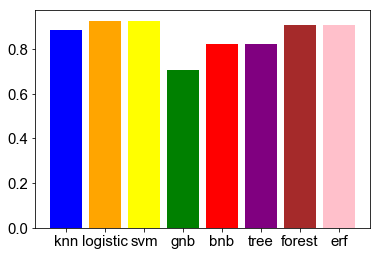

In [202]:
accuracy_scores = []

for element in grid_outputs:
    accuracy_scores.append(grid_outputs[element].best_score_)

plt.bar(['knn','logistic','svm','gnb','bnb','tree','forest','erf'], accuracy_scores, color=['b','orange','yellow','g','r','purple','brown','pink'])
plt.rcParams['font.size'] = 15

([<matplotlib.axis.XTick at 0x1a187d6c88>,
 <a list of 8 Text xticklabel objects>)

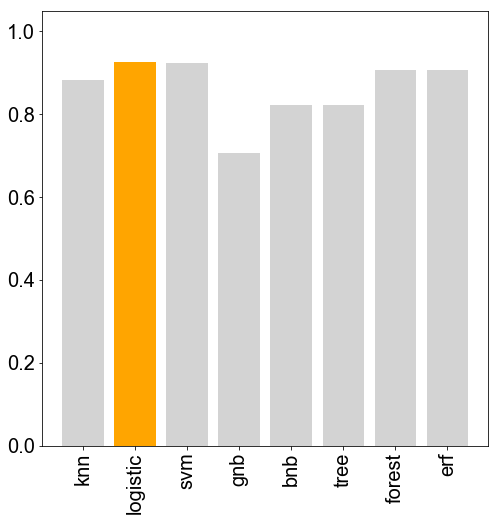

In [212]:
accuracy_scores = []
labels = ['knn','logistic','svm','gnb','bnb','tree','forest','erf']

for element in grid_outputs:
    accuracy_scores.append(grid_outputs[element].best_score_)

plt.figure(figsize=[8,8])
plt.bar(labels, accuracy_scores, color=['lightgray','orange','lightgray','lightgray','lightgray','lightgray','lightgray','lightgray'])
plt.rcParams['font.size'] = 20
plt.ylim([0.0, 1.05])
plt.xticks(labels, rotation='vertical')
    

In [ ]:
['knn','logistic','svm','gnb','bnb','tree','forest','erf'],

In [31]:
for element in sscaler_grid_outputs:
    print(element, sscaler_grid_outputs[element].best_score_)


knn 0.868607181719
logistic 0.920701849837
svm 0.908868335147
gnb 0.706882480958
bnb 0.779107725789
tree 0.823177366703
forest 0.907100108814
erf 0.906964091404


In [150]:
best_fit_models = {}
predicted_y_values = {}


for element in grid_outputs:
    best_fit = grid_outputs[element].best_estimator_.fit(X_train, np.ravel(y_train))
    best_fit_models[element] = best_fit
    y_train_pred = best_fit.predict(X_train)
    predicted_y_values[element] = y_train_pred
    print(element, ": ", classification_report(y_train, y_train_pred), confusion_matrix(y_train, y_train_pred))


knn :                precision    recall  f1-score   support

           1       0.99      1.00      1.00      1226
           2       0.99      0.99      0.99      1073
           3       1.00      0.98      0.99       986
           4       0.96      0.88      0.92      1286
           5       0.90      0.97      0.93      1374
           6       1.00      1.00      1.00      1407

   micro avg       0.97      0.97      0.97      7352
   macro avg       0.97      0.97      0.97      7352
weighted avg       0.97      0.97      0.97      7352
 [[1226    0    0    0    0    0]
 [   6 1067    0    0    0    0]
 [   6    9  971    0    0    0]
 [   0    1    0 1129  151    5]
 [   0    0    0   47 1327    0]
 [   0    0    1    1    0 1405]]


/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


logistic :                precision    recall  f1-score   support

           1       1.00      1.00      1.00      1226
           2       1.00      1.00      1.00      1073
           3       1.00      1.00      1.00       986
           4       0.98      0.98      0.98      1286
           5       0.98      0.98      0.98      1374
           6       1.00      1.00      1.00      1407

   micro avg       0.99      0.99      0.99      7352
   macro avg       0.99      0.99      0.99      7352
weighted avg       0.99      0.99      0.99      7352
 [[1226    0    0    0    0    0]
 [   0 1073    0    0    0    0]
 [   0    0  986    0    0    0]
 [   0    0    0 1258   28    0]
 [   0    0    0   28 1346    0]
 [   0    0    0    0    0 1407]]
svm :                precision    recall  f1-score   support

           1       1.00      1.00      1.00      1226
           2       1.00      1.00      1.00      1073
           3       1.00      1.00      1.00       986
           4       0.9

In [144]:
best_fit_models = {}
predicted_y_values = {}

#Get K-Folds and predict proba
grouped_kfold = GroupKFold(n_splits=3)
groups = np.array(y_train_merged['SubjectID'])
folds = grouped_kfold.split(np.array(X_train), np.array(y_train), groups)

# for element in grid_outputs:
#     best_fit = grid_outputs[element].best_estimator_.fit(X_train, np.ravel(y_train))
#     best_fit_models[element] = best_fit
#     y_train_pred = best_fit.predict(X_train)
#     predicted_y_values[element] = y_train_pred
#     print(element, ": ", classification_report(y_train, y_train_pred), confusion_matrix(y_train, y_train_pred))

for element in grid_outputs:    
    y_train_pred = cross_val_predict(
        grid_outputs[element].best_estimator_, 
        X_train, 
        np.ravel(y_train), 
        cv=folds, 
        method='predict_proba', 
        n_jobs=-1)
    print(element, ": ", classification_report(y_train, y_train_pred), confusion_matrix(y_train, y_train_pred))


ValueError: Classification metrics can't handle a mix of multiclass and continuous-multioutput targets

In [306]:
def ROC_Plot_one_model(X_train, y_train, model):
    #Get K-Folds and predict proba
    grouped_kfold = GroupKFold(n_splits=3)
    groups = np.array(y_train_merged['SubjectID'])
    folds = grouped_kfold.split(np.array(X_train), np.array(y_train), groups)
    
    # Get "out of sample" y predictions using cross val predict
    y_pred_CV = cross_val_predict(
        model, 
        X_train, 
        np.ravel(y_train), 
        cv=folds, 
        method='predict_proba', 
        n_jobs=-1)
    
    #Bin labels so now y has as many colunms as classes
    y_train_bin = label_binarize(y_train, classes=[1,2,3,4,5,6])
    n_classes = 6# y_train_bin.shape[1]
    
    # Compute ROC curve and ROC area for each class
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(n_classes):
        fpr[i], tpr[i], thresholds = roc_curve(y_train_bin[:, i], y_pred_CV[:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    # First aggregate all false positive rates across classes
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    
    
    
    plt.figure(figsize=[8,8])
    
    lw=2
                
    plt.plot(fpr["macro"], tpr["macro"],
         label='Macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue','r','pink','g'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='{0} (area = {1:0.2f})'.format(activity[1][i], roc_auc[i]))
# "My name is {0}".format('Fred')
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Logistic Regression ROC curve')
    plt.legend(loc="lower right")
    plt.rcParams['font.size'] = 20
    plt.show()
    
    plt.savefig("LOGREG_Curves_Train.svg")

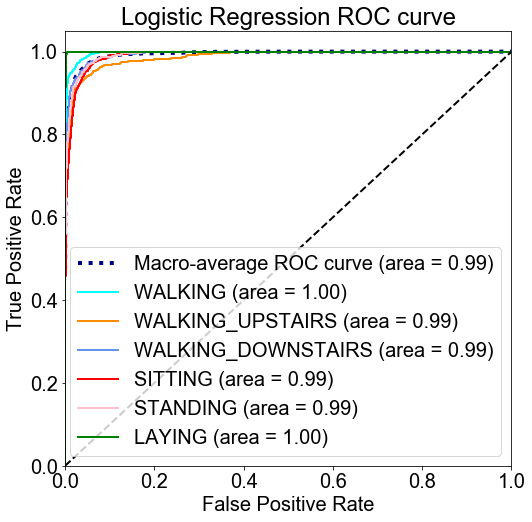

<Figure size 432x288 with 0 Axes>

In [307]:
ROC_Plot_one_model(X_train, y_train, best_fit_models['logistic'])

In [308]:
best_fit_models['logistic']

LogisticRegression(C=1.873817422860385, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [159]:
best_fit_models_no_svm = best_fit_models
del best_fit_models_no_svm['svm']

KeyError: 'svm'

In [86]:
def get_ROC_Plot_data(X_train, y_train, model):
    #Get K-Folds and predict proba
    grouped_kfold = GroupKFold(n_splits=3)
    groups = np.array(y_train_merged['SubjectID'])
    folds = grouped_kfold.split(np.array(X_train), np.array(y_train), groups)
    
    # Get "out of sample" y predictions using cross val predict
    y_pred_CV = cross_val_predict(
        model, 
        X_train, 
        np.ravel(y_train), 
        cv=folds, 
        method='predict_proba', 
        n_jobs=-1)
    
    #Bin labels so now y has as many colunms as classes
    y_train_bin = label_binarize(y_train, classes=[1,2,3,4,5,6])
    n_classes = 6# y_train_bin.shape[1]
    
    # Compute ROC curve and ROC area for each class
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(n_classes):
        fpr[i], tpr[i], thresholds = roc_curve(y_train_bin[:, i], y_pred_CV[:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    # First aggregate all false positive rates across classes
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    return fpr["macro"], tpr["macro"], roc_auc["macro"] 
    

In [291]:
def plot_all_ROC_curves(X_train, y_train, model_dict):
    plt.figure(figsize=[8,8])
        
    fpr = {}
    tpr = {}
    roc_auc = {}
    
    for model_name, model_formula in model_dict.items():
        fpr["macro"], tpr["macro"], roc_auc["macro"] = get_ROC_Plot_data(X_train, y_train, model_formula)
        lw=2
        plt.plot(fpr["macro"], tpr["macro"],
                 label=model_name+' (area = {0:0.2f})'
                       ''.format(roc_auc["macro"]))
#                  linestyle=':', linewidth=4)
    
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) curve')
    plt.legend(loc="lower right")
    plt.rcParams['font.size'] = 20
#     plt.rcParams['font.sans-serif'] = 'Arial'
#     plt.xaxis.label.set_color('red')
#     plt.tick_params(axis='x', colors='red')
    plt.show()
    
    plt.savefig("ROC_Curves_Train.svg")

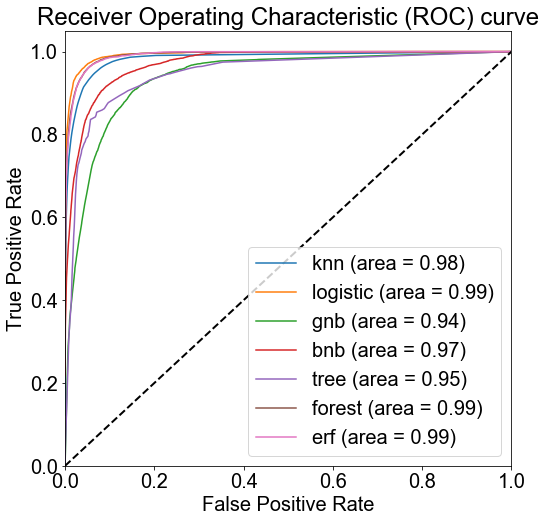

<Figure size 432x288 with 0 Axes>

In [292]:
plot_all_ROC_curves(X_train, y_train, best_fit_models_no_svm)

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

def plot_coefficients(model, ci=95):
    """
    Plots coefficients and their confidence intervals for a statsmodels OLS
    model. Based on (but heavily modified and simplified) 
    seaborn's now deprecated coefplot.
    See 
    https://github.com/mwaskom/seaborn/blob/master/seaborn/regression.py

Args:
    model: statsmodels OLS model
        model whose params and confidence intervals to plot
    ci: float, optional
        size of confidence intervals

Returns:

"""
# Get basic information to prepare the plot
alpha = 1 - ci / 100
coefs = model.params
cis = model.conf_int(alpha)
n_terms = len(coefs)

# Figure out the dimensions of the plot
h, w = mpl.rcParams["figure.figsize"]
f, ax = plt.subplots(1, 1, figsize=(
n_terms * (1 / 2), n_terms * (h / (4 * (n_terms / 5)))))
for i, term in enumerate(coefs.index):
    low, high = cis.loc[term]
    ax.plot([low, high], [i, i], solid_capstyle="round", lw=2.5,
            color='black')
    ax.plot(coefs.loc[term], i, "o", ms=8, color='black')
ax.set_ylim(-.5, n_terms - .5)
ax.set_yticks(range(n_terms))
coef_names = coefs.index.values
ax.set_yticklabels(coef_names)
plt.setp(ax.get_xticklabels(), rotation=90)

In [303]:
for item1, item2 in zip(features[1], best_fit_models['logistic'].coef_[5]):
    print(item1, ", ", item2)

tBodyAcc-mean()-X ,  -0.100747875453
tBodyAcc-mean()-Y ,  0.00314791566527
tBodyAcc-mean()-Z ,  0.0606554696889
tBodyAcc-std()-X ,  0.0019633740631
tBodyAcc-std()-Y ,  -0.0535886007172
tBodyAcc-std()-Z ,  0.0179048731625
tBodyAcc-mad()-X ,  0.0071910267128
tBodyAcc-mad()-Y ,  -0.056130890529
tBodyAcc-mad()-Z ,  0.0205454416378
tBodyAcc-max()-X ,  -0.113920319736
tBodyAcc-max()-Y ,  -0.00956477381995
tBodyAcc-max()-Z ,  0.0742089789919
tBodyAcc-min()-X ,  -0.0748238021997
tBodyAcc-min()-Y ,  0.051350035288
tBodyAcc-min()-Z ,  0.0551257622772
tBodyAcc-sma() ,  -0.00562106878762
tBodyAcc-energy()-X ,  0.0162613861434
tBodyAcc-energy()-Y ,  -0.00957760926654
tBodyAcc-energy()-Z ,  0.0532571437188
tBodyAcc-iqr()-X ,  0.0160497101293
tBodyAcc-iqr()-Y ,  -0.0525291370064
tBodyAcc-iqr()-Z ,  0.0201192500734
tBodyAcc-entropy()-X ,  0.169303752391
tBodyAcc-entropy()-Y ,  0.0748715921352
tBodyAcc-entropy()-Z ,  0.280384920648
tBodyAcc-arCoeff()-X,1 ,  -0.00484471612287
tBodyAcc-arCoeff()-X,2 ,  0

## 6. Testing our chosen model

In [145]:
features = pd.read_csv('UCI HAR dataset/features.txt', delim_whitespace=True, header=None)
activity = pd.read_csv('UCI HAR dataset/activity_labels.txt', delim_whitespace=True, header=None)
subject_test = pd.read_csv('UCI HAR dataset/test/subject_test.txt', delim_whitespace=True, header=None)
X_test = pd.read_csv('UCI HAR dataset/test/X_test.txt', delim_whitespace=True, header=None)
y_test = pd.read_csv('UCI HAR dataset/test/y_test.txt', delim_whitespace=True, header=None)


In [ ]:
grid_outputs_test={}

In [225]:
predicted_y_values = {}


for element in grid_outputs:
    y_test_pred = best_fit_models[element].predict(X_test)
    predicted_y_values[element]=y_test_pred
    print(element, ": ", accuracy_score(y_test, y_test_pred), classification_report(y_test, y_test_pred), confusion_matrix(y_test, y_test_pred))


knn :  0.904309467255               precision    recall  f1-score   support

           1       0.84      0.98      0.91       496
           2       0.90      0.91      0.90       471
           3       0.96      0.77      0.86       420
           4       0.92      0.79      0.85       491
           5       0.83      0.94      0.89       532
           6       1.00      1.00      1.00       537

   micro avg       0.90      0.90      0.90      2947
   macro avg       0.91      0.90      0.90      2947
weighted avg       0.91      0.90      0.90      2947
 [[488   0   8   0   0   0]
 [ 39 427   5   0   0   0]
 [ 51  44 325   0   0   0]
 [  0   4   0 389  98   0]
 [  0   0   0  31 501   0]
 [  0   0   0   1   1 535]]
logistic :  0.962334577536               precision    recall  f1-score   support

           1       0.94      1.00      0.97       496
           2       0.97      0.95      0.96       471
           3       1.00      0.97      0.98       420
           4       0.97     

KeyError: 'svm'

In [226]:
predicted_y_values

{'knn': array([5, 5, 5, ..., 2, 2, 1]),
 'logistic': array([5, 5, 5, ..., 2, 2, 2])}

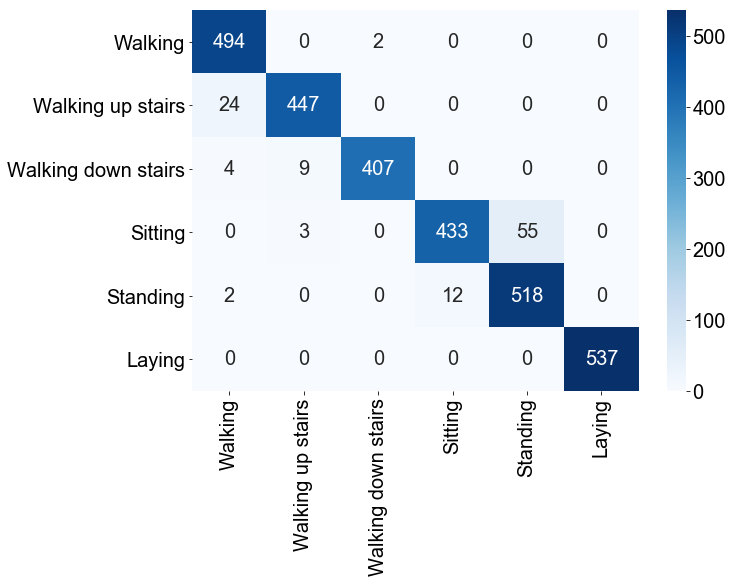

In [242]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

array = confusion_matrix(y_test, predicted_y_values['logistic'])

act = ['Walking', 'Walking up stairs', 'Walking down stairs', 'Sitting', 'Standing', 'Laying']

df_cm = pd.DataFrame(array, index = [i for i in act],
                  columns = [i for i in act])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g', cmap="Blues")
plt.rcParams['font.size'] = 20


In [250]:
print(accuracy_score(y_test, predicted_y_values['logistic']), classification_report(y_test, predicted_y_values['logistic']))

0.962334577536               precision    recall  f1-score   support

           1       0.94      1.00      0.97       496
           2       0.97      0.95      0.96       471
           3       1.00      0.97      0.98       420
           4       0.97      0.88      0.93       491
           5       0.90      0.97      0.94       532
           6       1.00      1.00      1.00       537

   micro avg       0.96      0.96      0.96      2947
   macro avg       0.96      0.96      0.96      2947
weighted avg       0.96      0.96      0.96      2947



--------
## 5. Feature Selection

In [19]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

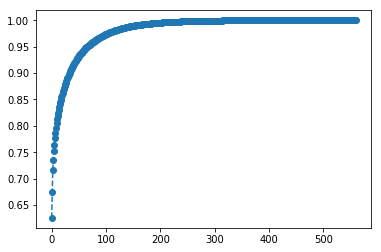

In [20]:
plt.plot(pca.explained_variance_ratio_.cumsum().reshape(561,1), '--o')

In [31]:
cumulative_varience_explained = pca.explained_variance_ratio_.cumsum().reshape(561,1)
cumulative_varience_explained = pd.DataFrame(cumulative_varience_explained)
cumulative_varience_explained.head()
# Need to keep 66 PCAs to get to 95% variability or 154 to keep 99% of variability

,0
0,0.625544
1,0.674675
2,0.715889
3,0.734639
4,0.751587


In [22]:
pca_99 = PCA(n_components=154)
pca_99.fit(X_train)
X_train_PCA = pd.DataFrame(pca_99.transform(X_train))

### <span style="color:red">Need to Turn this into a threshold formula^ </span>

--------
## 5. Fit Models on limited feature space

In [68]:
models = [('knn', KNeighborsClassifier), 
          ('logistic', LogisticRegression),
          ('tree', DecisionTreeClassifier),
          ('forest', RandomForestClassifier),
          ('boost', GradientBoostingClassifier),
          ('svm', svm.SVC)
         ]

param_choices = [
    {
        'n_neighbors': (1, 100)
    },
    {
        'C': (-3, 6, 'log-uniform'),
        'penalty': ['l1', 'l2']
    },
    {
        'max_depth': (1,5),
        'min_samples_leaf': (1,10)
    },
    {
        'n_estimators': (50,300),
        'criterion': ['gini', 'entropy'],
        'max_depth': (2,50), 
        'max_features': (1,25),
        'min_samples_split': (2,50)
    },
    {
        'learning_rate': (.001,1,'log-uniform'), 
        'max_features': (1,25), 
        'subsample': (.001,1,'log-uniform'),
        'n_estimators': (50,300),
        'min_samples_split': (2,25)
    },
    {
        'gamma': (.001,1,'log-uniform'), 
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
    }
]


bayes_grid_pca ={}
bayes_best_models_pca = {}
bayes_scores_pca = {}
bayes_parameters_pca = {}


for model_info, params in zip(models, param_choices):

    grouped_kfold = GroupKFold(n_splits=3)
    groups = np.array(y_train_merged['SubjectID'])
    folds = grouped_kfold.split(np.array(X_train_PCA), np.array(y_train), groups)

    name, model = model_info
    grid = BayesSearchCV(model(), params, cv=folds)
    bayes_grid_pca.fit(X_train_PCA, np.ravel(y_train))
    n = f"{name}: best score: {grid.best_score_}"
    p = f"{name}: best parameters: {grid.best_params_}"
    print(n)
    print(p)
    bayes_grid_pca[name] = grid
    bayes_best_models_pca[name]= grid.best_params_
    bayes_scores_pca[name] = grid.best_estimator_
    bayes_parameters_pca[name]= grid.best_params_

AttributeError: 'dict' object has no attribute 'fit'

In [29]:
models = [('knn', KNeighborsClassifier), 
          ('logistic', LogisticRegression),
          ('tree', DecisionTreeClassifier),
          ('forest', RandomForestClassifier),
          ('boost', GradientBoostingClassifier),
          ('svm', svm.SVC)
         ]

param_choices = [
    {
        'n_neighbors': range(1, 50, 5)
    },
    {
        'C': np.logspace(-3,6, 12),
        'penalty': ['l1', 'l2']
    },
    {
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    },
    {
        'n_estimators': [50, 200],
        'criterion': ['gini', 'entropy'],
        'max_depth': [15, 20, None], 
        'max_features': [10, 15, 50, 'auto'],
        'min_samples_split': [2, 5, 25]
    },
    {
        'learning_rate': [.01,0.1,.5], 
        'max_features': [1, 10, "sqrt"], 
        'subsample': [0.01, 0.1, 1],
        'n_estimators': [100, 200, 400],
        'min_samples_split': [2,5,25]
    },
    {
        'gamma': [.0001,.001,.01,.1, 'scale','auto_deprecated'], 
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
    }
]

grid_pca ={}
best_models_pca = {}
scores_pca = {}
parameters_pca = {}

for model_info, params in zip(models, param_choices):

    grouped_kfold = GroupKFold(n_splits=3)
    groups = np.array(y_train_merged['SubjectID'])
    folds = grouped_kfold.split(np.array(X_train_PCA), np.array(y_train), groups)

    name, model = model_info
    grid = GridSearchCV(model(), params, cv=folds, n_jobs=-1)
    grid.fit(X_train_PCA, np.ravel(y_train))
    n = f"{name}: best score: {grid.best_score_}"
    p = f"{name}: best parameters: {grid.best_params_}"
    print(n)
    print(p)
    grid_pca[name] = grid
    best_models_pca[name]= grid.best_params_
    scores_pca[name] = grid.best_estimator_
    parameters_pca[name]= grid.best_params_
    

knn: best score: 0.8820729053318824
knn: best score: {'n_neighbors': 16}


/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


logistic: best score: 0.9228781284004353
logistic: best score: {'C': 1.873817422860385, 'penalty': 'l2'}
tree: best score: 0.7759793253536452
tree: best score: {'max_depth': 5, 'min_samples_leaf': 6}


/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


forest: best score: 0.8819368879216539
forest: best score: {'criterion': 'gini', 'max_depth': None, 'max_features': 10, 'min_samples_split': 5, 'n_estimators': 200}


/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


boost: best score: 0.9056039173014145
boost: best score: {'learning_rate': 0.1, 'max_features': 'sqrt', 'min_samples_split': 25, 'n_estimators': 400, 'subsample': 1}
svm: best score: 0.9224700761697497
svm: best score: {'gamma': 0.01, 'kernel': 'rbf'}


In [65]:
print(grid.best_estimator_)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


-------------
-------------
-------------

## Appendix

In [ ]:
# # THIS ONLY WORKS FOR BINARY CLASSIFICATION. I NEED ANOTHER VERSION FOR MULTI CLASS

# from sklearn.metrics import roc_auc_score
# from sklearn.metrics import roc_curve,auc

# knn_roc_auc = roc_auc_score(y_train, pred_train_knn_best)
# fpr, tpr, thresholds = roc_curve(y_train, knn_best_cv.predict_proba(X_train)[:,1])
# roc_auc = auc(fpr,tpr)

# plt.figure(figsize=(6,6))
# # Plotting our Baseline..
# plt.plot([0,1],[0,1],'r--')
# plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
# plt.legend(loc='lower right')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate');

In [ ]:
grouped_kfold = GroupKFold(n_splits=3)
groups = np.array(y_train_merged['SubjectID'])
folds = grouped_kfold.split(np.array(X_train), np.array(y_train), groups)

KNN_best_CV_train_pred = cross_val_predict(
    knn_best, 
    X_train, 
    np.ravel(y_train), 
    cv=folds,
    method=’predict’)

KNN_best_CV_train_pred_proba = cross_val_predict(
    knn_best, 
    X_train, 
    np.ravel(y_train), 
    cv=folds,
    method=’predict_proba’)


from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

knn_roc_auc = roc_auc_score(y_train, KNN_best_CV_train_pred)
fpr, tpr, thresholds = roc_curve(y_train, KNN_best_CV_train_pred_proba[:,1])
roc_auc = auc(fpr,tpr)

In [101]:
# How to get ROC Curves

# Here I generate grouped k-folds
from sklearn.model_selection import GroupKFold
grouped_kfold = GroupKFold(n_splits=3)
groups = np.array(y_train_merged['SubjectID'])
folds = grouped_kfold.split(np.array(X_train), np.array(y_train), groups)


# Here I fit a model using GridSearchCV to iterate through different K values 
# and cross validate using my predefined folds to find best K value
param_grid = dict(n_neighbors=list(range(1, 100,5)))
knn = KNeighborsClassifier(n_neighbors=13)
grid_knn = GridSearchCV(knn, param_grid, cv=folds, scoring='accuracy', n_jobs=-1)
grid_knn.fit(X_train, y_train['ActivityID']);
knn_best = grid_knn.best_estimator_

# I could fit my model on the full X_train dataset and then predict the y_trains.
# This will tend to give me higher accuracy because of overfitting and/or sample size effects
# If I want to build an ROC curve, this will tend to show my model performing better than it 
# would on test data because I am only capturing the in-sample error rate
knn_best.fit(X_train, np.ravel(y_train))
pred_train_knn_best = knn_best.predict(X_train)


# If I want to build an ROC curve we want to predict y as below. This method essentially predicts each y_i
# based on a model fit on the subset of X_train that excludes the fold in which y_i was contained
pred_train_KNN_best_CV = cross_val_predict(
    knn_best, 
    X_train, 
    np.ravel(y_train), 
    cv=folds)

# In summary:
# pred_train_knn_best - predicts all y_i's on the same model which was fit on all of X_train
# pred_train_KNN_best_CV  - each y_i is predicted with a model trained on out of sample folds

SyntaxError: invalid syntax (<ipython-input-101-4f19b24d1236>, line 11)

In [ ]:
model_svm_linear = svm.SVC(kernel='linear')
model_svm_linear.fit(X_train, y_train)

In [ ]:
pred_train_svm_linear = model_svm_linear.predict(X_train)
confusion_matrix(y_train, pred_train_svm_linear)

In [ ]:
from sklearn.metrics import confusion_matrix
accuracy_score(y_train, pred_train_svm_linear)

In [ ]:
model_svm_rbf = svm.SVC(kernel='rbf')
model_svm_rbf.fit(X_train, y_train)
pred_train_svm_rbf = model_svm_rbf.predict(X_train)

In [ ]:
accuracy_score(y_train, pred_train_svm_rbf)

### 4.1 KNN

In [42]:
from sklearn.model_selection import GroupKFold

grouped_kfold = GroupKFold(n_splits=3)
groups = np.array(y_train_merged['SubjectID'])
folds = grouped_kfold.split(np.array(X_train), np.array(y_train), groups)

In [46]:
k_range = list(range(1, 100,5))
param_grid = dict(n_neighbors=k_range)
knn = KNeighborsClassifier(n_neighbors=13)

In [44]:
grid_knn = GridSearchCV(knn, param_grid, cv=folds, scoring='accuracy', n_jobs=-1)

In [45]:
grid_knn.fit(X_train, y_train['ActivityID']);

KeyboardInterrupt: 

In [225]:
print(grid_knn.best_score_)
print(grid_knn.best_params_)
print(grid_knn.best_estimator_)

# went from ?90? to 88, K stayed 16 (before & after grouping kfolds)

0.882889009793
{'n_neighbors': 16}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=16, p=2,
           weights='uniform')


In [23]:
knn_best = grid_knn.best_estimator_
knn_best.fit(X_train, np.ravel(y_train))
pred_train_knn_best = knn_best.predict(X_train)

In [24]:
accuracy_score(y_train, pred_train_knn_best)

0.9683079434167573

In [25]:
confusion_matrix(y_train, pred_train_knn_best)


array([[1226,    0,    0,    0,    0,    0],
       [   6, 1067,    0,    0,    0,    0],
       [   8,    9,  969,    0,    0,    0],
       [   0,    1,    0, 1147,  133,    5],
       [   0,    0,    0,   68, 1306,    0],
       [   0,    0,    1,    2,    0, 1404]])

### 4.2 SVM

In [26]:
model_svm = svm.SVC(kernel='rbf', gamma='auto_deprecated')

# may want to add random_state=86 to be safe

In [28]:
param_grid_svm = {'gamma':[.0001,.001,.01,.1, 'scale','auto_deprecated'], 
              'kernel':['linear', 'poly', 'rbf', 'sigmoid']}

In [29]:
grouped_kfold = GroupKFold(n_splits=3)
groups = np.array(y_train_merged['SubjectID'])
folds = grouped_kfold.split(np.array(X_train), np.array(y_train), groups)

In [30]:
grid_svm = GridSearchCV(model_svm, param_grid_svm, cv=folds, scoring='accuracy', n_jobs=-1)

In [31]:
grid_svm.fit(X_train, y_train['ActivityID']);

/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [32]:
print(grid_svm.best_score_)
print(grid_svm.best_params_)
print(grid_svm.best_estimator_)

0.924102285092
{'gamma': 0.01, 'kernel': 'rbf'}
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


Before grouping our K-Folds, we believe the best option will be to use a linear model with gamma=0.01

After grouping K folds, the best is rbf with gamma of 0.01

In [33]:
svc_best = grid_svm.best_estimator_
svc_best.fit(X_train, np.ravel(y_train))
# y_pred = knn.predict(X_test)
# print(metrics.accuracy_score(y_test, y_pred))
pred_train_svc_best = svc_best.predict(X_train)

In [34]:
accuracy_score(y_train, pred_train_svc_best)

0.98340587595212192

In [35]:
confusion_matrix(y_train, pred_train_svc_best)

array([[1226,    0,    0,    0,    0,    0],
       [   1, 1071,    1,    0,    0,    0],
       [   0,    0,  986,    0,    0,    0],
       [   0,    1,    0, 1231,   54,    0],
       [   0,    0,    0,   65, 1309,    0],
       [   0,    0,    0,    0,    0, 1407]])

### 4.3 Random Forest

In [37]:
model_randforest = RandomForestClassifier(
    n_estimators=200, 
    criterion='gini', 
    max_depth=None, 
    max_features='auto',
    min_samples_split=5,
    random_state=47)

In [38]:
''' First time tried below model and got cv accuracy of 0.898394994559 
and in-sample of 1.0 so we definitely overfit'''

# param_grid_randforrest = {
#     'criterion':['gini', 'entropy'],
#     'max_depth':[None, 50,100], 
#     'max_features':['auto', 50]
# }

param_grid_randforest = {
    'n_estimators':[50, 200],
    'criterion':['gini', 'entropy'],
    'max_depth':[15, 20, None], 
    'max_features':[10, 15, 50, 'auto'],
    'min_samples_split':[2, 5, 25]
}



In [39]:
from sklearn.model_selection import GroupKFold

grouped_kfold = GroupKFold(n_splits=3)
groups = np.array(y_train_merged['SubjectID'])
folds = grouped_kfold.split(np.array(X_train), np.array(y_train), groups)


grid_randforest = GridSearchCV(model_randforest, param_grid_randforest, cv=folds, scoring='accuracy', n_jobs=-1)
grid_randforest.fit(X_train, np.ravel(y_train))

print(grid_randforest.best_score_)
print(grid_randforest.best_params_)
print(grid_randforest.best_estimator_)

/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:740: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


0.906147986942
{'criterion': 'entropy', 'max_depth': 20, 'max_features': 15, 'min_samples_split': 2, 'n_estimators': 200}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=20, max_features=15, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=47, verbose=0, warm_start=False)


In [40]:
randforest_best = grid_randforest.best_estimator_
randforest_best.fit(X_train, np.ravel(y_train))

# y_pred = knn.predict(X_test)
# print(metrics.accuracy_score(y_test, y_pred))
pred_train_randforest_best = randforest_best.predict(X_train)

In [41]:
accuracy_score(y_train, pred_train_randforest_best)

1.0

In [42]:
confusion_matrix(y_train, pred_train_randforest_best)

array([[1226,    0,    0,    0,    0,    0],
       [   0, 1073,    0,    0,    0,    0],
       [   0,    0,  986,    0,    0,    0],
       [   0,    0,    0, 1286,    0,    0],
       [   0,    0,    0,    0, 1374,    0],
       [   0,    0,    0,    0,    0, 1407]])

### <span style="color:red">Need to analyze an extra random forest i.e. random feature selection, not greedy. Is that the same as entropy? </span>

### 4.4 Gradient Boosting

In [44]:
model_gradboost = GradientBoostingClassifier(learning_rate=0.1, max_features=1, subsample=0.5,
n_estimators=200, min_samples_split=5)

In [50]:
param_grid_gradboost = {
    'learning_rate':[.01,0.1,.5], 
    'max_features':[1, 10, "sqrt"], 
    'subsample':[0.01, 0.1, 1],
    'n_estimators':[100, 200, 400],
    'min_samples_split':[2,5,25]
}

In [51]:

grouped_kfold = GroupKFold(n_splits=3)
groups = np.array(y_train_merged['SubjectID'])
folds = grouped_kfold.split(np.array(X_train), np.array(y_train), groups)


grid_gradboost = GridSearchCV(model_gradboost, param_grid_gradboost, cv=folds, scoring='accuracy', n_jobs=-1)
grid_gradboost.fit(X_train, np.ravel(y_train));

print(grid_gradboost.best_score_)
print(grid_gradboost.best_params_)
print(grid_gradboost.best_estimator_)

/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.908596300326
{'learning_rate': 0.1, 'max_features': 10, 'min_samples_split': 2, 'n_estimators': 400, 'subsample': 0.1}
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=10, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=400,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=0.1, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)


In [52]:
gradboost_best = grid_gradboost.best_estimator_
gradboost_best.fit(X_train, np.ravel(y_train))
# y_pred = knn.predict(X_test)
# print(metrics.accuracy_score(y_test, y_pred))
pred_train_gradboost_best = gradboost_best.predict(X_train)

In [53]:
accuracy_score(y_train, pred_train_gradboost_best)

1.0

In [54]:
confusion_matrix(y_train, pred_train_gradboost_best)

array([[1226,    0,    0,    0,    0,    0],
       [   0, 1073,    0,    0,    0,    0],
       [   0,    0,  986,    0,    0,    0],
       [   0,    0,    0, 1286,    0,    0],
       [   0,    0,    0,    0, 1374,    0],
       [   0,    0,    0,    0,    0, 1407]])

### 4.5 Logistic Regression

In [57]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train, y_train)

In [26]:

model_log_L2 = LogisticRegression(n_jobs=-1, C=1.0, tol=0.0001, solver ='newton-cg', max_iter=100, random_state = 42, multi_class='auto')


In [56]:
param_grid_log_L2 = {
    'C':[.05, .1, .5], 
#     'penalty':['l2','l1'],
    'tol':[0.000001, 0.0001, 0.001],
    'solver':['newton-cg', 'lbfgs', 'sag'],
    'max_iter':[100, 500]
}

In [ ]:
from skopt import gp_minimize


class BayesSearchCV(BayesSearchCV):
    def _run_search(self, x): raise BaseException('Use newer skopt')```

In [58]:
from sklearn.model_selection import GroupKFold

grouped_kfold = GroupKFold(n_splits=3)
groups = np.array(y_train_merged['SubjectID'])
folds = grouped_kfold.split(np.array(X_train), np.array(y_train), groups)


grid_log = GridSearchCV(model_log, param_grid_log, cv=folds, scoring='accuracy', n_jobs=-1)
grid_log.fit(X_train_scaled, np.ravel(y_train));

print(grid_log.best_score_)
print(grid_log.best_params_)
print(grid_log.best_estimator_)

0.912812840044
{'C': 0.5, 'max_iter': 500, 'solver': 'sag', 'tol': 1e-06}
LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500, multi_class='auto', n_jobs=-1,
          penalty='l2', random_state=42, solver='sag', tol=1e-06,
          verbose=0, warm_start=False)


/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [59]:
log_best = grid_log.best_estimator_
# y_pred = knn.predict(X_test)
# print(metrics.accuracy_score(y_test, y_pred))
pred_train_log_best = log_best.predict(X_train_scaled)

/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [60]:
accuracy_score(y_train, pred_train_log_best)

0.98680631120783457

In [61]:
confusion_matrix(y_train, pred_train_log_best)

array([[1225,    1,    0,    0,    0,    0],
       [   0, 1073,    0,    0,    0,    0],
       [   0,    0,  986,    0,    0,    0],
       [   0,    0,    0, 1236,   50,    0],
       [   0,    0,    0,   46, 1328,    0],
       [   0,    0,    0,    0,    0, 1407]])

In [ ]:
KNeighborsClassifier
LogisticRegression
DecisionTreeClassifier
RandomForestClassifier
ExtraTreesClassifier
GradientBoostingClassifier
svm.SVC
GaussianNB
BernoulliNB()

In [ ]:
models = [('knn', KNeighborsClassifier), 
          ('logistic', LogisticRegression),
          ('tree', DecisionTreeClassifier),
#           ('forest', RandomForestClassifier),
#           ('erf', ExtraTreesClassifier),
          ('svm', svm.SVC),
          ('gnb', GaussianNB),
          ('bnb', BernoulliNB)#,
#          ('boost', GradientBoostingClassifier),
         ]



param_choices = [
    {
        'n_neighbors': range(1, 100, 2)
    },
    {
        'C': np.logspace(-3,6, 12),
        'penalty': ['l1', 'l2']
    },
    {
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    },
#     {
#         'n_estimators': [50, 200],
#         'criterion': ['gini', 'entropy'],
#         'max_depth': [15, 20, None], 
#         'max_features': [10, 15, 50, 'auto'],
#         'min_samples_split': [2, 5, 25]
#     },
#     { 
#         'max_features': [1, 10, 'auto'],
#         'criterion': ['gini', 'entropy'],
#         'n_estimators': [100, 200],
#         'min_samples_split': [2,5,20],
#         'min_impurity_decrease': [0, 1e-3, 1e-2],
#         'bootstrap': [True,False],
#         'max_depth': [3, 10, None] 
#     }, 
    {
        'gamma': [.0001,.001,.01,.1, 'scale','auto_deprecated'], 
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
    },
    {
        'var_smoothing' : [1e-10, 1e-9, 1e-8]
    },
    {
        'alpha': [.5, 1.0, 5],
        'binarize': [0.0, 6.0]
    },
#     {
#         'n_estimators': [100, 200],
#         'criterion': ['friedman_mse', 'mse', 'mae'],
#         'max_depth': [3, 10], 
#         'max_features': [10, 'auto'],
#         'min_samples_split': [2, 5, 25],
#         'learning_rate': [.01,0.1,.5],
#         'subsample': [0.01, 0.1, 1],
#         'min_impurity_decrease': [0, 1e-3, 1e-2]
#     }
]
    
for model_info, params in zip(models, param_choices):

    grouped_kfold = GroupKFold(n_splits=3)
    groups = np.array(y_train_merged['SubjectID'])
    folds = grouped_kfold.split(np.array(X_train), np.array(y_train), groups)

    name, model = model_info
    grid = GridSearchCV(model(), params, cv=folds, n_jobs=7)
    grid.fit(X_train, np.ravel(y_train))
    print(name)
    
    grid_outputs[name] = grid
    best_models[name]= grid.best_estimator_
    scores[name] = grid.best_score_
    parameters[name]= grid.best_params_


In [78]:
models = [('knn', KNeighborsClassifier), 
          ('logistic', LogisticRegression),
          ('tree', DecisionTreeClassifier),
          ('forest', RandomForestClassifier),
          ('erf', ExtraTreesClassifier),
          ('boost', GradientBoostingClassifier),
          ('svm', svm.SVC),
          ('gnb', GaussianNB),
          ('bnb', BernoulliNB),
         ]



param_choices = [
    {
        'n_neighbors': range(1, 100, 5)
    },
    {
        'C': np.logspace(-3,6, 12),
        'penalty': ['l1', 'l2']
    },
    {
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    },
    {
        'n_estimators': [50, 200],
        'criterion': ['gini', 'entropy'],
        'max_depth': [15, 20, None], 
        'max_features': [10, 15, 50, 'auto'],
        'min_samples_split': [2, 5, 25]
    },
    {
        'n_estimators': [50, 200],
        'criterion': ['gini', 'entropy'],
        'max_depth': [15, 20, None], 
        'max_features': [10, 15, 50, 'auto'],
        'min_samples_split': [2, 5, 25]
    },
    {
        'learning_rate': [.01,0.1,.5], 
        'max_features': [1, 10, "sqrt"], 
        'subsample': [0.01, 0.1, 1],
        'n_estimators': [100, 200, 400],
        'min_samples_split': [2,5,25],
        'min_impurity_decrease': [0, 1e-3, 1e-2],
        'bootstrap': [True,False],
        'oob_score': [True,False],
    },
    {
        'gamma': [.0001,.001,.01,.1, 'scale','auto_deprecated'], 
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
    },
    {
        'var_smoothing' : [1e-10, 1e-9, 1e-8]
    },
    {
        'alpha': [.5, 1.0, 5],
        'binarize': [0.0, 6.0]
    }
]


grid_outputs = {}
best_models = {}
scores = {}
parameters = {}

    
for model_info, params in zip(models, param_choices):

    grouped_kfold = GroupKFold(n_splits=3)
    groups = np.array(y_train_merged['SubjectID'])
    folds = grouped_kfold.split(np.array(X_train), np.array(y_train), groups)

    name, model = model_info
    grid = GridSearchCV(model(), params, cv=folds, n_jobs=-1)
    grid.fit(X_train, np.ravel(y_train))
    n = f"{name}: best score: {grid.best_score_}"
    p = f"{name}: best parameters: {grid.best_params_}"
    print(n)
    print(p)
    
    grid_outputs[name] = grid
    best_models[name]= grid.best_params_
    scores[name] = grid.best_estimator_
    parameters[name]= grid.best_params_

knn: best score: 0.8828890097932536
knn: best parameters: {'n_neighbors': 16}


/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


logistic: best score: 0.926550598476605
logistic: best parameters: {'C': 1.873817422860385, 'penalty': 'l2'}


/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


tree: best score: 0.8188248095756256
tree: best parameters: {'max_depth': 4, 'min_samples_leaf': 3}
forest: best score: 0.904923830250272
forest: best parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 15, 'min_samples_split': 5, 'n_estimators': 200}


/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


erf: best score: 0.9073721436343852
erf: best parameters: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 50, 'min_samples_split': 5, 'n_estimators': 200}


ValueError: Invalid parameter bootstrap for estimator GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False). Check the list of available parameters with `estimator.get_params().keys()`.

In [ ]:
GradientBoostingClassifier()
ExtraTreesClassifier()

In [80]:
models = [#('knn', KNeighborsClassifier), 
          #('logistic', LogisticRegression),
          #('tree', DecisionTreeClassifier),
          #('forest', RandomForestClassifier),
          ('boost', GradientBoostingClassifier),
          ('erf', ExtraTreesClassifier),
          ('svm', svm.SVC),
          ('gnb', GaussianNB),
          ('bnb', BernoulliNB),
         ]



param_choices = [
#     {
#         'n_neighbors': range(1, 100, 5)
#     },
#     {
#         'C': np.logspace(-3,6, 12),
#         'penalty': ['l1', 'l2']
#     },
#     {
#         'max_depth': [1,2,3,4,5],
#         'min_samples_leaf': [3,6,10]
#     },
#     {
#         'n_estimators': [50, 200],
#         'criterion': ['gini', 'entropy'],
#         'max_depth': [15, 20, None], 
#         'max_features': [10, 15, 50, 'auto'],
#         'min_samples_split': [2, 5, 25]
#     },
    {
        'n_estimators': [50, 200],
        'criterion': ['friedman_mse', 'mse', 'mae'],
        'max_depth': [15, 20, None], 
        'max_features': [10, 15, 50, 'auto'],
        'min_samples_split': [2, 5, 25]
    },
    {
        'learning_rate': [.01,0.1,.5], 
        'max_features': [1, 10, "sqrt"], 
        'subsample': [0.01, 0.1, 1],
        'n_estimators': [100, 200, 400],
        'min_samples_split': [2,5,25],
        'min_impurity_decrease': [0, 1e-3, 1e-2],
        'bootstrap': [True,False],
        'oob_score': [True,False],
    },
    {
        'gamma': [.0001,.001,.01,.1, 'scale','auto_deprecated'], 
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
    },
    {
        'var_smoothing' : [1e-10, 1e-9, 1e-8]
    },
    {
        'alpha': [.5, 1.0, 5],
        'binarize': [0.0, 6.0]
    }
]

    
for model_info, params in zip(models, param_choices):

    grouped_kfold = GroupKFold(n_splits=3)
    groups = np.array(y_train_merged['SubjectID'])
    folds = grouped_kfold.split(np.array(X_train), np.array(y_train), groups)

    name, model = model_info
    grid = GridSearchCV(model(), params, cv=folds, n_jobs=-1)
    grid.fit(X_train, np.ravel(y_train))
    n = f"{name}: best score: {grid.best_score_}"
    p = f"{name}: best parameters: {grid.best_params_}"
    print(n)
    print(p)
    
    grid_outputs[name] = grid
    best_models[name]= grid.best_params_
    scores[name] = grid.best_estimator_
    parameters[name]= grid.best_params_

/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


KeyboardInterrupt: 

In [97]:
for element in grid_outputs:
    print(element, grid_outputs[element].best_score_)
    
    #OLD

knn 0.882889009793
logistic 0.926550598477
tree 0.818824809576
forest 0.90492383025
erf 0.907372143634
